### Gerekli Kütüphaneler

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import seaborn as sns
from networkx.algorithms import community
from pyvis.network import Network
import time
import random
import pandas as pd
from matplotlib import cm
import requests
import gzip
import os

### Veri Setinin İndirilmesi ve NetworkX Kütüphanesi ile Import Edilmesi

In [2]:
# URL for the web-Google.txt.gz dataset
url = "http://snap.stanford.edu/data/web-Google.txt.gz"

# File paths
gz_file_path = "web-Google.txt.gz"
txt_file_path = "web-Google.txt"

# Download the dataset if it doesn't exist locally
if not os.path.exists(gz_file_path):
    print(f"Downloading {url}...")
    response = requests.get(url, stream=True)
    with open(gz_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download completed!")
else:
    print(f"File {gz_file_path} already exists.")

# Extract the .gz file if the .txt file doesn't exist locally
if not os.path.exists(txt_file_path):
    print(f"Extracting {gz_file_path}...")
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(txt_file_path, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Extraction completed!")
else:
    print(f"File {txt_file_path} already exists.")

print("Creating the directed graph...")
G = nx.DiGraph()

with open(txt_file_path, 'r') as f:
    for line in f:
        line = line.strip()
        # Skip comment lines
        if line.startswith('#'):
            continue
        # Parse the edge information
        nodes = line.split()
        if len(nodes) >= 2:
            from_node = int(nodes[0])
            to_node = int(nodes[1])
            G.add_edge(from_node, to_node)

print(f"Graph created successfully!")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

File web-Google.txt.gz already exists.
File web-Google.txt already exists.
Creating the directed graph...
Graph created successfully!
Number of nodes: 875713
Number of edges: 5105039


### Graf Örnekleme (Graph Sampling)


Büyük grafı örnekleme...
Orijinal graf: 875713 düğüm, 5105039 kenar
PageRank hesaplanıyor...
Graf tam bağlı değil, en büyük bileşeni seçiyoruz...

Örneklenmiş graf özellikleri:
Düğüm sayısı: 7489
Kenar sayısı: 56611
Ortalama kümeleme katsayısı: 0.5215352611989861
Ortalama en kısa yol uzunluğu hesaplanıyor (örnekleme ile)...
Ortalama en kısa yol uzunluğu (örneklenmiş): 8.2462
Ortalama gelen derece: 7.5592
Ortalama giden derece: 7.5592
Maksimum gelen derece: 4731
Maksimum giden derece: 110

Orijinal ve örneklenmiş graf karşılaştırması:
Orijinal: 875713 düğüm, 5105039 kenar
Örneklenmiş: 7489 düğüm, 56611 kenar
Azaltma oranı (düğümler): 0.0086
Azaltma oranı (kenarlar): 0.0111


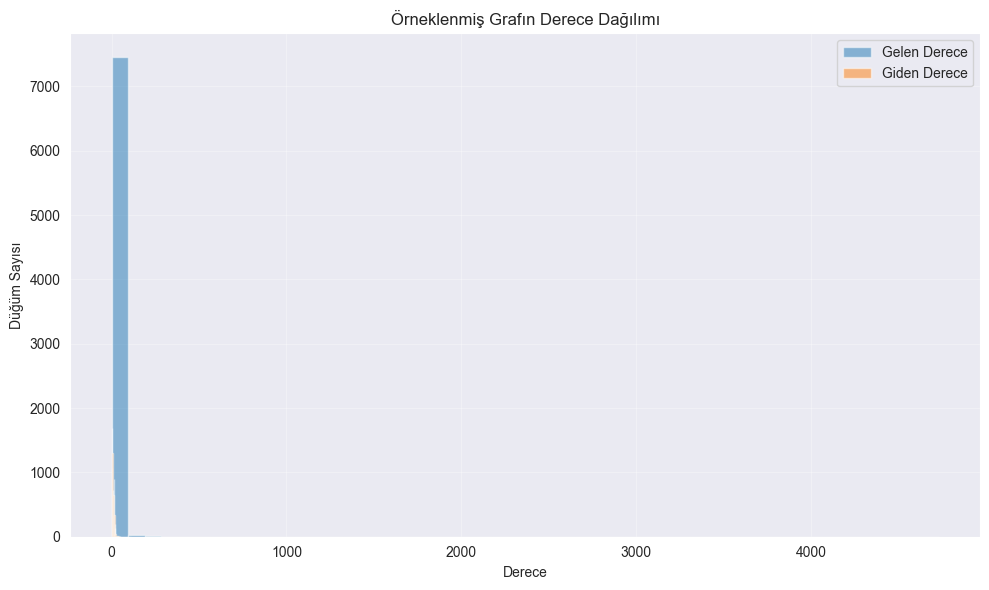

In [3]:
# Graf örnekleme teknikleri uygulayarak daha küçük bir graf oluşturalım
print("Büyük grafı örnekleme...")
print(f"Orijinal graf: {G.number_of_nodes()} düğüm, {G.number_of_edges()} kenar")

# Stratejimiz:
# 1. Yüksek PageRank skoruna sahip önemli düğümlerden başlayarak
# 2. Bunların etrafındaki toplulukları (komşulukları) alarak
# 3. 5000-10000 düğümlük bir alt graf oluşturacağız

# PageRank hesaplayarak önemli düğümleri bulalım
print("PageRank hesaplanıyor...")
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

# En yüksek PageRank değerine sahip düğümleri sıralayalım
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
top_nodes = [node for node, score in top_nodes[:500]]  # En önemli 500 düğüm

# Bu önemli düğümler ve çevrelerini temel alan örnekleme yapalım
# İlk olarak, belirli sayıda önemli düğümü seçelim (hedef düğüm sayısına göre)
seed_nodes = set(top_nodes[:100])  # En önemli 100 düğümü seçiyoruz
target_nodes = 7500  # Hedeflenen düğüm sayısı (5000-10000 arası)

# Bu çekirdek düğümleri genişletelim
current_nodes = seed_nodes.copy()
frontier = seed_nodes.copy()
visited = set()

# BFS benzeri bir yaklaşımla genişletelim, ancak önceliği yüksek PageRank'e verelim
while len(current_nodes) < target_nodes and frontier:
    # Sınırdaki düğümleri PageRank'e göre sırala
    frontier_ranks = [(n, pagerank.get(n, 0)) for n in frontier]
    frontier_ranks.sort(key=lambda x: x[1], reverse=True)

    # En yüksek PageRank'li düğümü seç
    current = frontier_ranks[0][0]
    frontier.remove(current)
    visited.add(current)

    # Komşularını ekle
    neighbors = set(G.successors(current)) | set(G.predecessors(current))
    neighbors = neighbors - visited

    # Eğer hala hedef düğüm sayısına ulaşmadıysak, komşuları ekle
    if len(current_nodes) + len(neighbors) <= target_nodes:
        current_nodes.update(neighbors)
        frontier.update(neighbors)
    else:
        # Hedef sayıya ulaşacak kadar komşu ekle
        remaining = target_nodes - len(current_nodes)
        # Komşuları PageRank'e göre sırala ve en önemlilerini ekle
        neighbors_ranks = [(n, pagerank.get(n, 0)) for n in neighbors]
        neighbors_ranks.sort(key=lambda x: x[1], reverse=True)
        top_remaining = [n for n, _ in neighbors_ranks[:remaining]]
        current_nodes.update(top_remaining)
        break

# Alt graf oluştur
G_sample = G.subgraph(current_nodes).copy()

# Bağlı bileşenler arasında en büyüğünü seç
if not nx.is_strongly_connected(G_sample):
    print("Graf tam bağlı değil, en büyük bileşeni seçiyoruz...")
    largest_cc = max(nx.weakly_connected_components(G_sample), key=len)
    G_sample = G_sample.subgraph(largest_cc).copy()

# Graf metriklerini hesapla ve göster
print("\nÖrneklenmiş graf özellikleri:")
print(f"Düğüm sayısı: {G_sample.number_of_nodes()}")
print(f"Kenar sayısı: {G_sample.number_of_edges()}")
print(f"Ortalama kümeleme katsayısı: {nx.average_clustering(G_sample)}")
print(f"Ortalama en kısa yol uzunluğu hesaplanıyor (örnekleme ile)...")

# En kısa yol uzunluğunu tahmin etmek için örnekleme (çok büyük graflarda tam hesaplama yavaş olabilir)
sample_size = min(100, G_sample.number_of_nodes())
sampled_nodes = random.sample(list(G_sample.nodes()), sample_size)
path_lengths = []

for u in sampled_nodes:
    for v in sampled_nodes:
        if u != v:
            try:
                path_lengths.append(nx.shortest_path_length(G_sample, u, v))
            except nx.NetworkXNoPath:
                # Yol yoksa eklemiyoruz
                pass

if path_lengths:
    print(f"Ortalama en kısa yol uzunluğu (örneklenmiş): {np.mean(path_lengths):.4f}")

# Derece dağılımını kontrol edelim
in_degrees = [d for n, d in G_sample.in_degree()]
out_degrees = [d for n, d in G_sample.out_degree()]

print(f"Ortalama gelen derece: {np.mean(in_degrees):.4f}")
print(f"Ortalama giden derece: {np.mean(out_degrees):.4f}")
print(f"Maksimum gelen derece: {np.max(in_degrees)}")
print(f"Maksimum giden derece: {np.max(out_degrees)}")

# Orijinal grafla basit karşılaştırma
print("\nOrijinal ve örneklenmiş graf karşılaştırması:")
print(f"Orijinal: {G.number_of_nodes()} düğüm, {G.number_of_edges()} kenar")
print(f"Örneklenmiş: {G_sample.number_of_nodes()} düğüm, {G_sample.number_of_edges()} kenar")
print(f"Azaltma oranı (düğümler): {G_sample.number_of_nodes() / G.number_of_nodes():.4f}")
print(f"Azaltma oranı (kenarlar): {G_sample.number_of_edges() / G.number_of_edges():.4f}")

# Örneklenmiş grafın derece dağılımını görselleştirelim
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=50, alpha=0.5, label='Gelen Derece')
plt.hist(out_degrees, bins=50, alpha=0.5, label='Giden Derece')
plt.xlabel('Derece')
plt.ylabel('Düğüm Sayısı')
plt.title('Örneklenmiş Grafın Derece Dağılımı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Test İçin Örneklenmiş Grafın Kullanılması (Tercihi)

In [4]:
G = G_sample

### Temel İstatistikler

#### Düğüm ve Kenar Sayısı

In [5]:
print(f"Düğüm Sayısı: {G.number_of_nodes()}")
print(f"Kenar Sayısı: {G.number_of_edges()}")

Düğüm Sayısı: 7489
Kenar Sayısı: 56611


#### İç ve dış derece

In [6]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
degree = dict(G.degree)

print(f"Ortalama Derece: {np.mean(list(degree.values())):.2f}")
print(f"Ortalama İç Derece: {np.mean(list(in_degrees.values())):.2f}")
print(f"Ortalama Dış Derece: {np.mean(list(out_degrees.values())):.2f}")

Ortalama Derece: 15.12
Ortalama İç Derece: 7.56
Ortalama Dış Derece: 7.56


#### Ağ Yoğunluğu

In [7]:
print(f"Ağ Yoğunluğu: {nx.density(G):.8f}")

Ağ Yoğunluğu: 0.00100951


#### Bağlantı güçleri

In [8]:
strong_components = list(nx.strongly_connected_components(G))
weak_components = list(nx.weakly_connected_components(G))

print(f"Strongly Connected Components sayısı: {len(strong_components)}")
print(f"Weakly Connected Components sayısı: {len(weak_components)}")

largest_strong = max(strong_components, key=len)
largest_weak = max(weak_components, key=len)

print(f"En büyük Strongly Connected Component boyutu: {len(largest_strong)}")
print(f"En büyük Weakly Connected Component boyutu: {len(largest_weak)}")

Strongly Connected Components sayısı: 2604
Weakly Connected Components sayısı: 1
En büyük Strongly Connected Component boyutu: 4244
En büyük Weakly Connected Component boyutu: 7489


#### Derece Dağılım Analizi

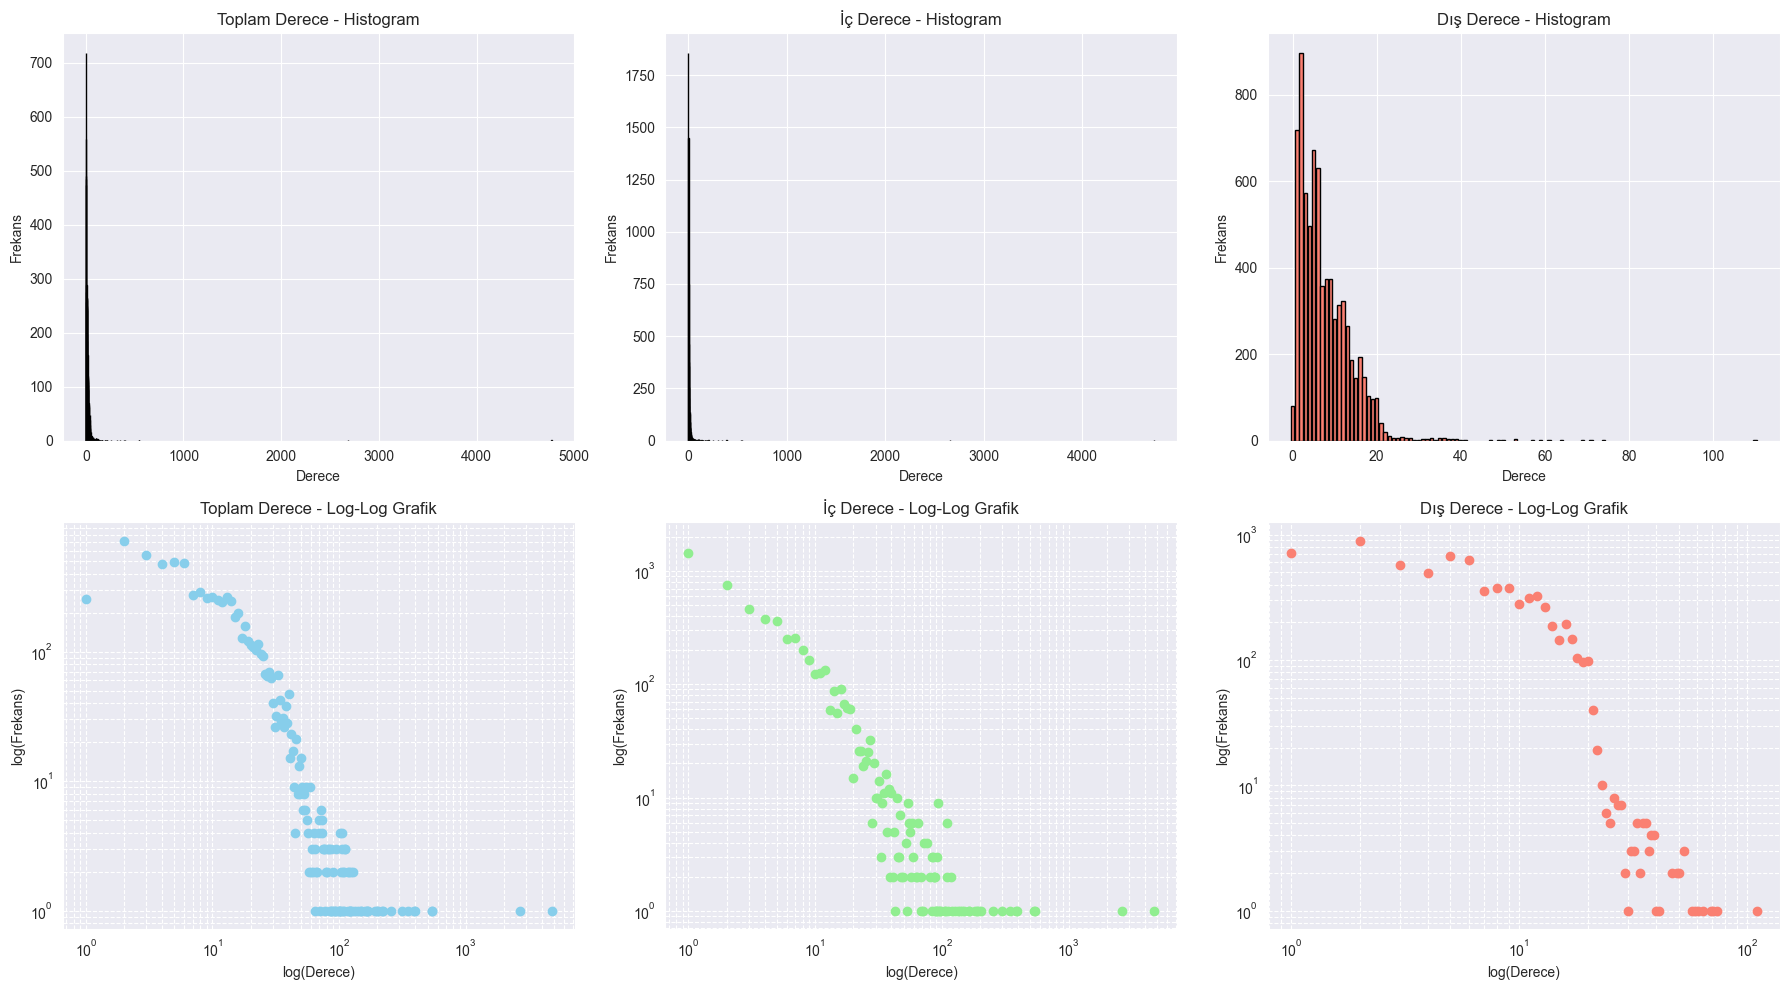

In [9]:
toplam_derece_listesi = [d for n, d in G.degree()]
ic_derece_listesi = [d for n, d in G.in_degree()]
dis_derece_listesi = [d for n, d in G.out_degree()]

dereceler = [
    ("Toplam Derece", toplam_derece_listesi, 'skyblue'),
    ("İç Derece", ic_derece_listesi, 'lightgreen'),
    ("Dış Derece", dis_derece_listesi, 'salmon')
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 satır 3 sütun

for i, (baslik, derece_listesi, renk) in enumerate(dereceler):
    derece_sayimi = collections.Counter(derece_listesi)
    derece, frekans = zip(*sorted(derece_sayimi.items()))

    axs[0, i].bar(derece, frekans, width=0.8, color=renk, edgecolor='black')
    axs[0, i].set_title(f"{baslik} - Histogram")
    axs[0, i].set_xlabel("Derece")
    axs[0, i].set_ylabel("Frekans")
    axs[0, i].grid(True)

    axs[1, i].loglog(derece, frekans, marker='o', linestyle='None', color=renk)
    axs[1, i].set_title(f"{baslik} - Log-Log Grafik")
    axs[1, i].set_xlabel("log(Derece)")
    axs[1, i].set_ylabel("log(Frekans)")
    axs[1, i].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()